Pitch Estimation

Incarcare librarii

In [2]:
import numpy as np
import librosa, librosa.display
import matplotlib.pyplot as plt
import IPython.display as disp

Incarcare fisier audio

In [3]:
filename = 'in_padurea_cu_alune.wav'
y, sr = librosa.load(filename)
print(sr)

22050


Redare fisier audio

In [108]:
disp.Audio(y, rate=sr)

CQT

In [109]:
bins_per_octave = 12
cqt = librosa.cqt(y, sr=sr, n_bins = 72, bins_per_octave = bins_per_octave)
log_cqt = librosa.amplitude_to_db(np.abs(cqt))

In [110]:
cqt.shape

(72, 277)

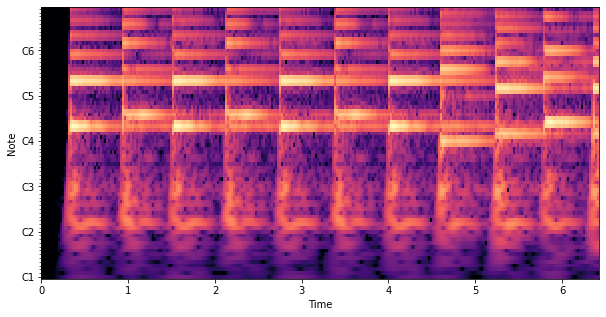

In [111]:
plt.figure(figsize=(10,5))
librosa.display.specshow(log_cqt, sr=sr, x_axis='time', y_axis='cqt_note', bins_per_octave = bins_per_octave)

Detect Onsets function

In [112]:
hop = 512
onset_env = librosa.onset.onset_strength(y, sr=sr, hop_length = hop)

(0.0, 277.0)

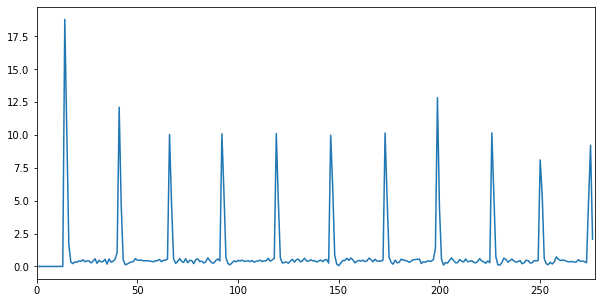

In [113]:
plt.figure(figsize=(10,5))
plt.plot(onset_env)
plt.xlim(0, len(onset_env))

Actual detection

In [114]:
onset_samples = librosa.onset.onset_detect(y, sr=sr, units='samples', hop_length = 100, 
                                           backtrack = False, pre_max = 20, post_max = 20, pre_avg= 100, 
                                           post_avg = 100, delta = 0.2, wait = 0)

In [115]:
onset_samples

array([  6900,  20600,  33500,  46900,  60700,  74500,  88300, 101500,
       115400, 127800, 140300])

Inceputul si sfarsitul semnalului - onsets

In [116]:
onset_boundaries = np.concatenate([[0], onset_samples, [len(y)]])

In [117]:
print (onset_boundaries)

[     0   6900  20600  33500  46900  60700  74500  88300 101500 115400
 127800 140300 141744]


Convertire din units in secunde

In [118]:
onset_times = librosa.samples_to_time(onset_boundaries, sr=sr)

In [119]:
print(onset_times)

[0.         0.31292517 0.93424036 1.51927438 2.12698413 2.75283447
 3.37868481 4.00453515 4.6031746  5.23356009 5.79591837 6.36281179
 6.42829932]


Grafic Onsets

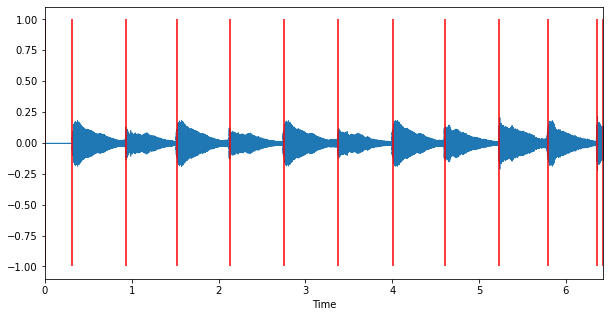

In [120]:
plt.figure(figsize=(10,5))
librosa.display.waveplot(y, sr=sr)
plt.vlines(onset_times, -1, 1, color = 'r')

Estimare pitch - se foloseste autocorelatia

In [121]:
def estimare_pitch(segment, sr, fmin=80.0, fmax=200.0):
    #Autocorelatie a segmentului
    r = librosa.autocorrelate(segment)
    
    #se defineste timpul minim si maxim si se egaleaza cu 0 tot ce este inainte si dupa ei
    tmax = sr/fmin
    tmin = sr/fmax
    
    r[:int(tmin)] = 0
    r[int(tmax):] = 0
    
    #autocorelatia maxima
    t = r.argmax()
    f0 = float(sr)/t
    return f0

Generare ton pur

In [122]:
def generare_sin(f0, sr, n_duration):
    n = np.arange(n_duration)
    return 0.2*np.sin(2*np.pi*f0*n/float(sr))

In [123]:
def estimate_pitch_and_generate_sine(y, onset_samples, t, sr):
    n0 = onset_samples[t]
    n1 = onset_samples[t+1]
    f0 = estimare_pitch(y[n0:n1], sr)
    return generare_sin(f0, sr, n1-n0)

Creare lista ce concateneaza segmentele

In [124]:
seg_list = np.concatenate([estimate_pitch_and_generate_sine(y, onset_boundaries, t, sr=sr)
                          for t in range(len(onset_boundaries)-1)
                          ])

In [125]:
disp.Audio(seg_list, rate=sr)

In [126]:
cqt = librosa.cqt(seg_list, sr=sr)

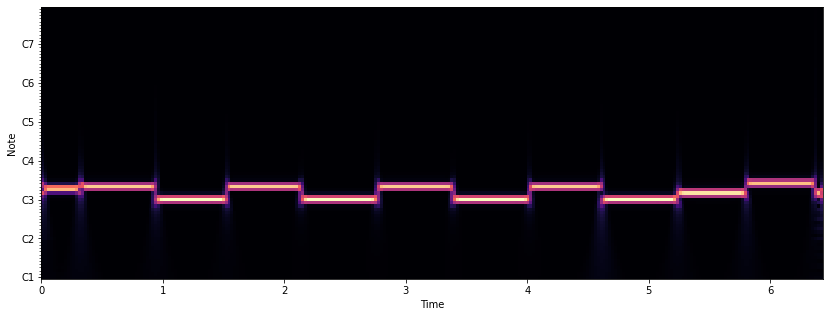

In [127]:
plt.figure(figsize=(14,5)), plt.plot
spec = librosa.display.specshow(abs(cqt), sr=sr, x_axis='time', y_axis='cqt_note', hop_length = 512)